In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [2]:
# import zipfile
import os

# zip_file_path = 'vsb-power-line-fault-detection.zip'
extract_folder = 'existing_folder'

# # Create the folder if it doesn't exist
# os.makedirs(extract_folder, exist_ok=True)

# # Open the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all contents into the existing folder
#     zip_ref.extractall(extract_folder)

# List the files in the existing folder
extracted_files = os.listdir(extract_folder)
print("Extracted Files:", extracted_files)

Extracted Files: ['sample_submission.csv', 'train.parquet', 'metadata_train.csv', 'metadata_test.csv', 'test.parquet']


In [3]:
parquet_file_path = os.path.join(extract_folder, 'train.parquet')
signals = pq.read_table(parquet_file_path, columns=[str(i) for i in range(999)]).to_pandas()


In [4]:
signals.head()

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,18,1,-19,-16,-5,19,-15,15,-1,-16,...,4,-18,10,9,18,-20,1,18,-19,-6
1,18,0,-19,-17,-6,19,-17,16,0,-15,...,1,-20,8,8,20,-19,2,18,-18,-6
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,...,1,-20,6,6,17,-22,0,18,-18,-6
3,18,1,-19,-16,-5,20,-16,16,0,-15,...,3,-21,5,6,18,-19,1,18,-18,-6
4,18,0,-19,-16,-5,20,-17,16,-2,-14,...,3,-20,5,6,19,-21,1,19,-18,-5


In [5]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 999 entries, 0 to 998
dtypes: int8(999)
memory usage: 762.2 MB


In [6]:


signals = np.array(signals).T.reshape((999//3, 3, 800000))



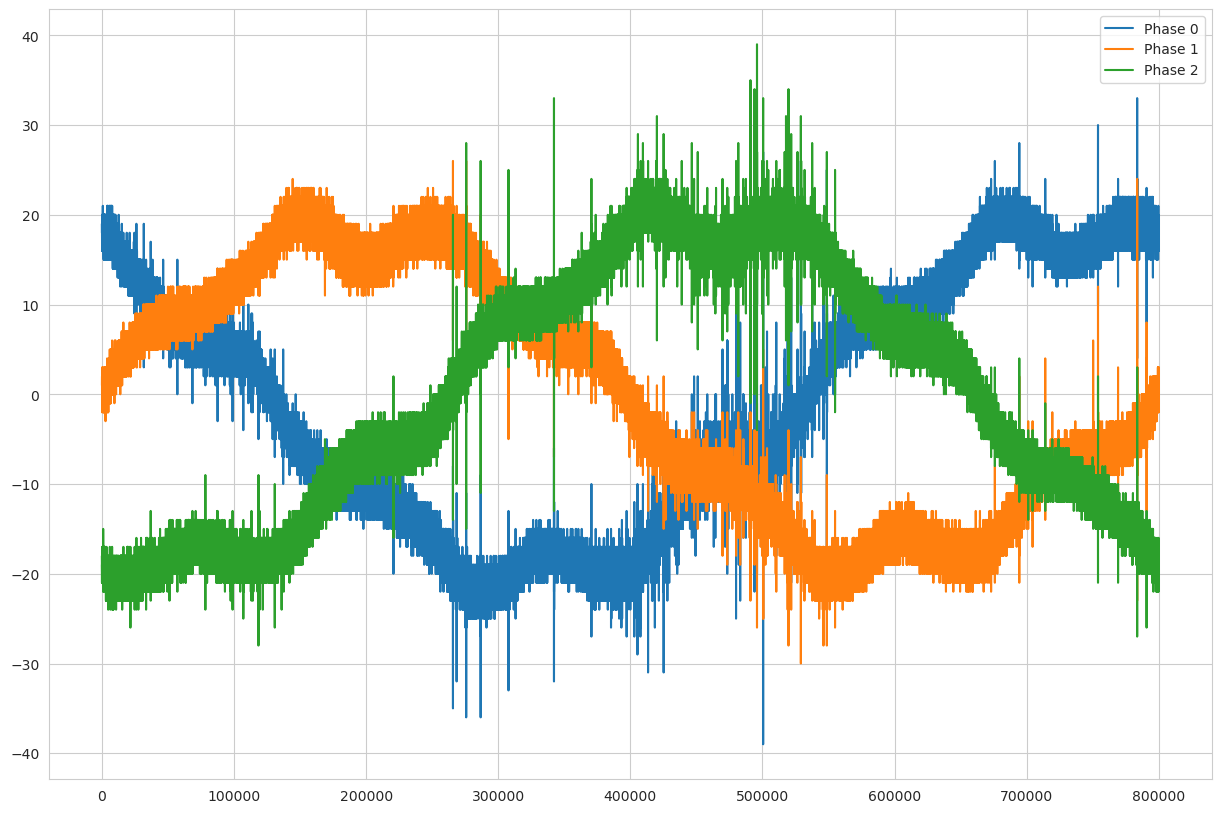

In [7]:


plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Phase 0')
plt.plot(signals[0, 1, :], label='Phase 1')
plt.plot(signals[0, 2, :], label='Phase 2')
plt.legend()
plt.show()



In [8]:
csv_file_path = os.path.join(extract_folder, 'metadata_train.csv')

train_df = pd.read_csv(csv_file_path)
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [9]:
target = train_df['target'][::3]

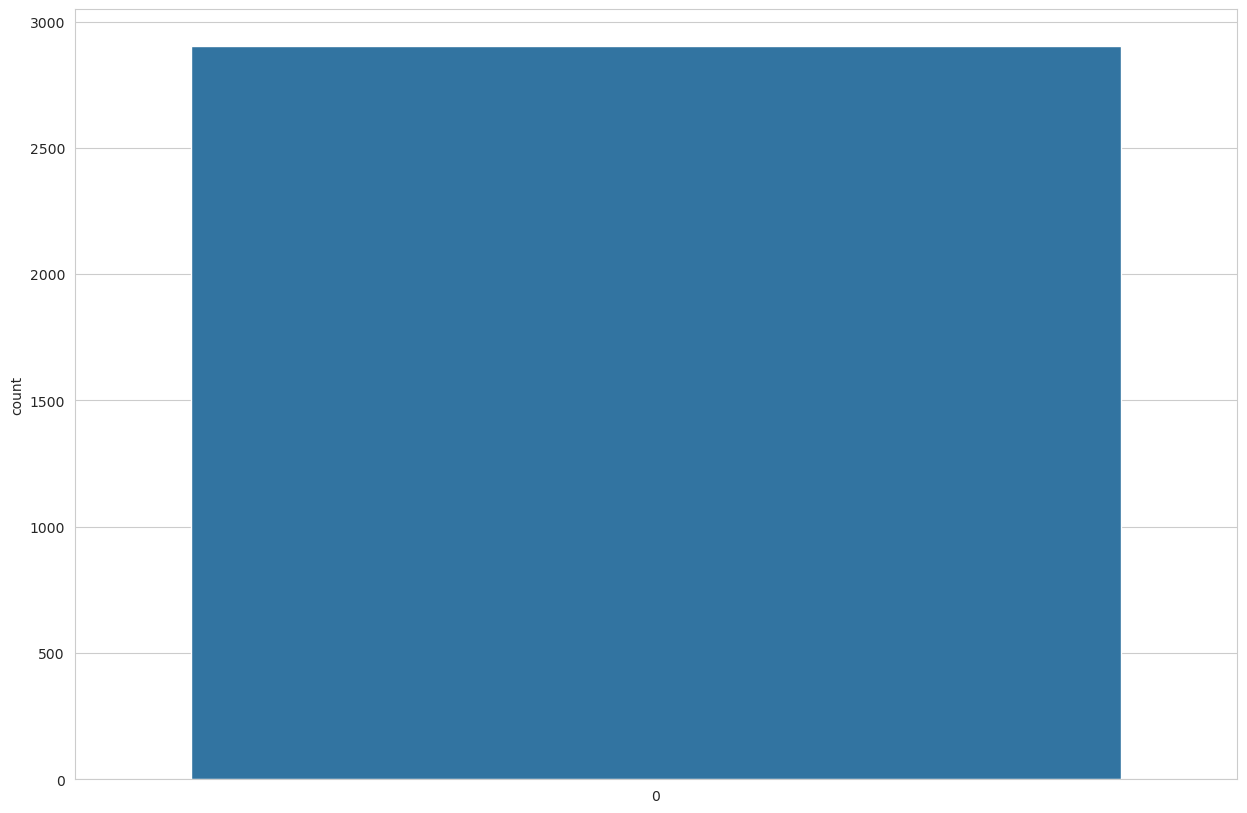

In [10]:


plt.figure(figsize=(15, 10))
sns.countplot(target)
plt.show()



In [11]:

#2 - Smoothing by mean

#The idea is to reduce the length and the noise of the signal by merging k

#neighbour values into their average.

def sample(signal, kernel_size):
    sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))
    for i in range(signal.shape[2]//kernel_size):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)
    return sampled



In [12]:
sampled = sample(signals, 100)

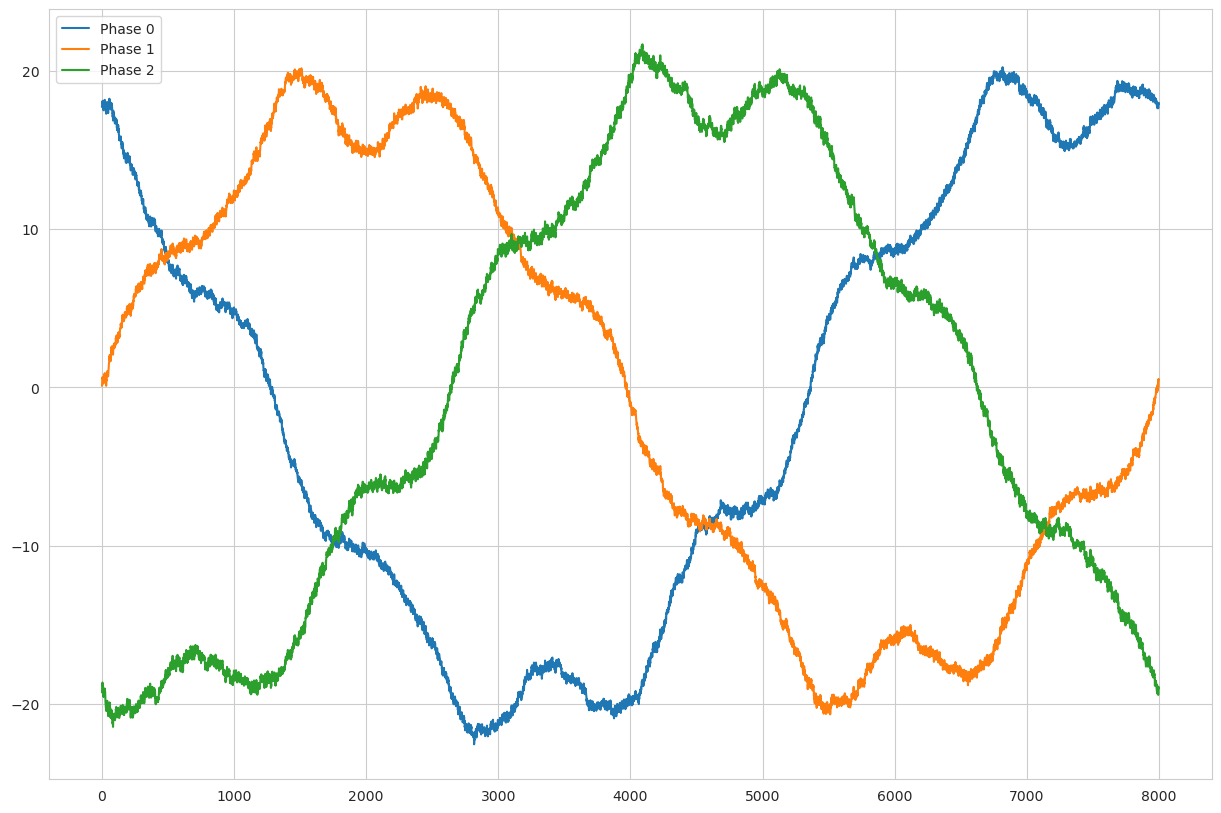

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(sampled[0, 0, :], label='Phase 0')
plt.plot(sampled[0, 1, :], label='Phase 1')
plt.plot(sampled[0, 2, :], label='Phase 2')
plt.legend()
plt.show()


In [14]:
"""""3 - Fast Fourier Transform denoising
A little bit of maths ...

The Fourier Transform of an 1D signal x
of length n

is the following :

    fj=∑n−1k=0xke2πinjk,  ∀j=0,...,n−1

The idea is to represent the signal in the complex space, It is roughly a sum of sinusoïdal functions. And there is one coefficient per frequency present in the signal.

The frequency takes the following values :

    f=1dn[0,1,…,n2−1,−n2,…,−1]

if n
is even
f=1dn[0,1,…,n−12,−n−12,…,−1]
if n

    is odd

Denoising algorithm

The denoising steps are the following :

    Apply the fft to the signal
    Compute the frequencies associated with each coefficient
    Keep only the coefficients which have a low enough frequency (in absolute)
    Compute the inverse fft"""""

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)



In [15]:

#Testing some thresholds

filtered = filter_signal(signals[0, 0, :], threshold=1e3)



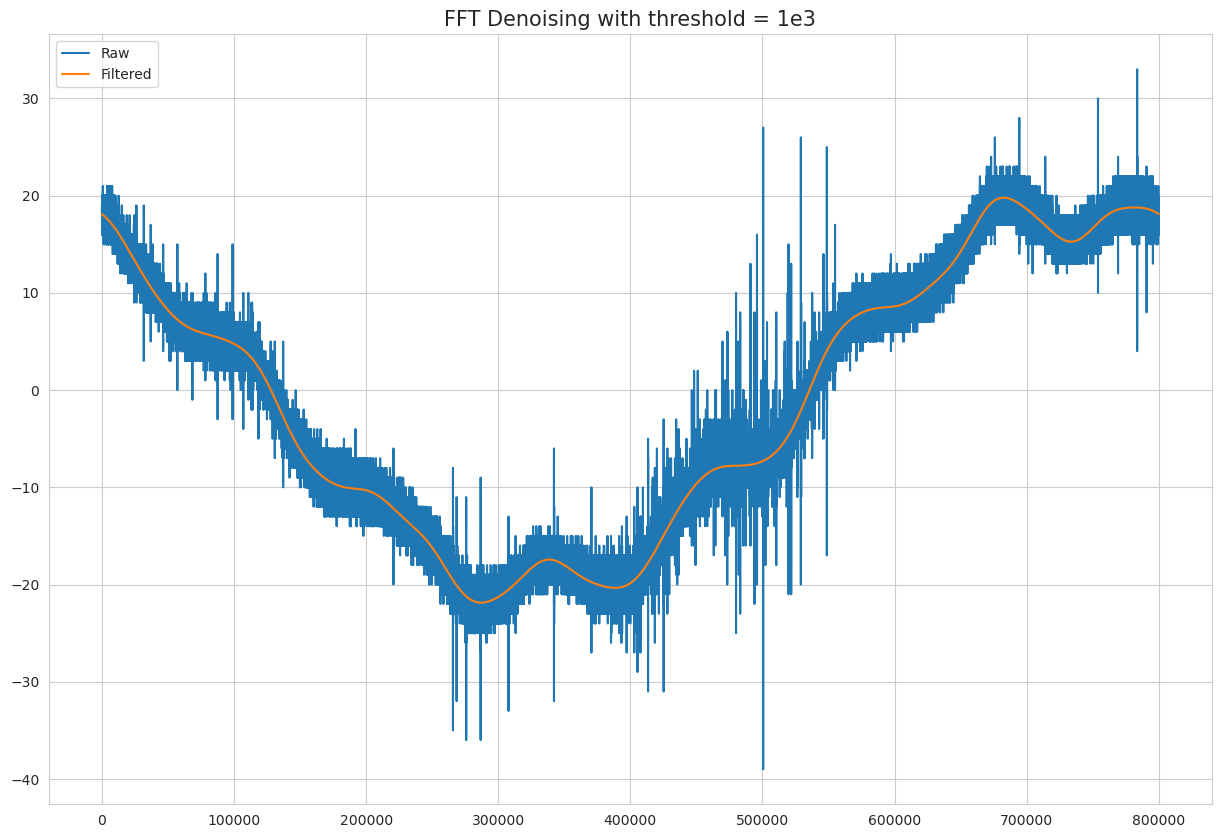

In [16]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e3", size=15)
plt.show()

In [17]:
filtered = filter_signal(signals[0, 0, :], threshold=1e5)

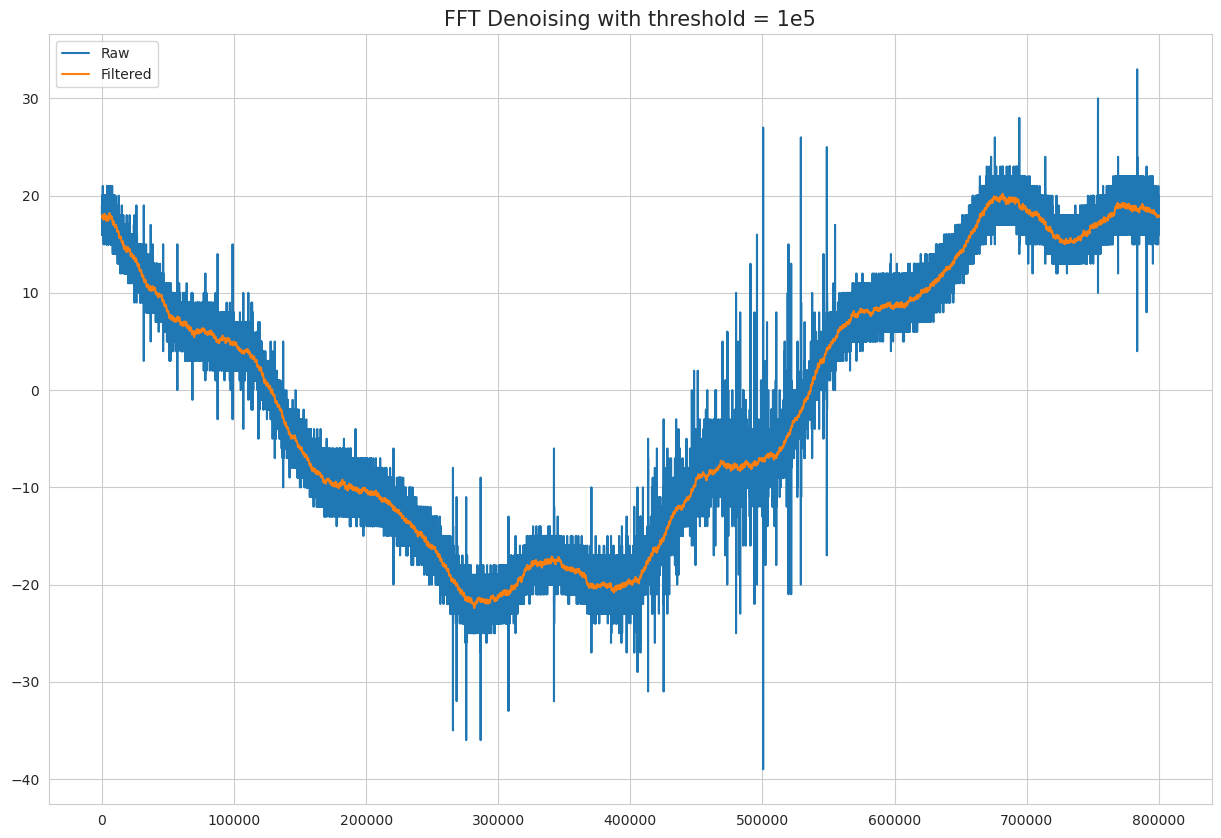

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e5", size=15)
plt.show()


In [19]:


filtered = filter_signal(signals[0, 0, :], threshold=1e7)



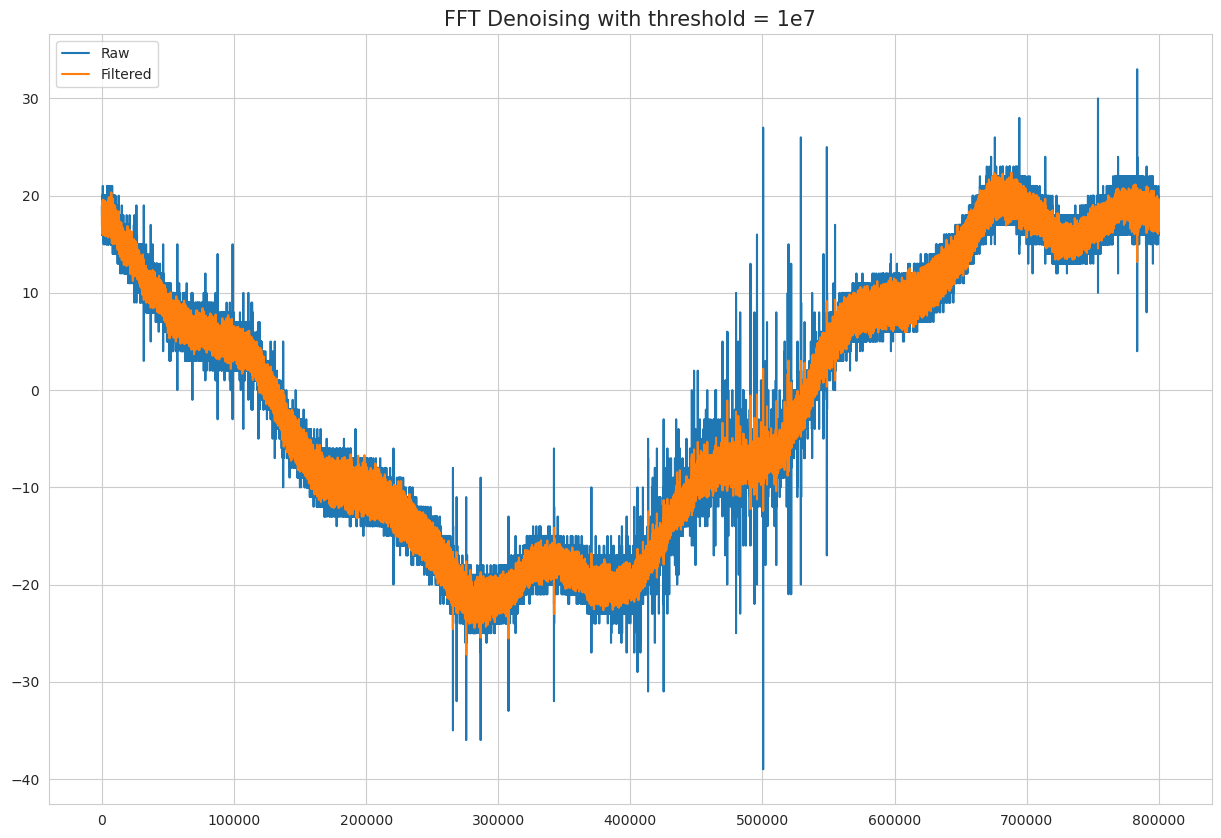

In [20]:


plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e7", size=15)
plt.show()

